In [1]:
# # Enable remote debugging
# import debugpy
# import os

# # Only enable debugging if not already enabled
# if not debugpy.is_client_connected():
#     debugpy.listen(("localhost", 5678))
#     print("Waiting for debugger to attach...")
#     debugpy.wait_for_client()
#     print("Debugger attached!")

In [2]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio as gr
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent
import pprint


import webbrowser
import threading
from pathlib import Path



[00:05:36 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '8029306', 'name': 'Games', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '10010034', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010033', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010038', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010040', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8029307', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '8029305', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '10010036', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010035', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010039', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010037', 'name': '_jobs', 'system': 

In [6]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[00:05:40 -0600] [INFO]: Graph 'SteamGraph' exists.
[00:05:40 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14951 nodes and 70478 edges


In [7]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jT9AiBa---', 'numberOfShards': 1, 'replicationFactor': 3, 'minReplicationFactor': 1, 'writeConcern': 1, 'isSmart': False, 'isSatellite': False, 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [8]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Users/294834367 Users/294834367
Users/65152385 Users/65152385
Users/262445620 Users/262445620
Games/12463_rfactor Games/12463_rfactor
Users/169427688 Users/169427688
Games/12552_pixel_piracy Games/12552_pixel_piracy
Users/303871659 Users/303871659
Users/194893507 Users/194893507
Users/216598286 Users/216598286
Users/39673466 Users/39673466


In [9]:
print(G_adb)

Graph named 'SteamGraph' with 14951 nodes and 70478 edges


### AQL Test

In [10]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
_analyzers
_apps
Games
plays
_graphs
_frontend
_queues
Users
_aqlfunctions
_appbundles
_jobs

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [11]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '126843636', '_id': 'Users/126843636', '_rev': '_jT6zLD2--c', 'type': 'Users', 'steamid': 126843636}
{'_key': '125895194', '_id': 'Users/125895194', '_rev': '_jT6zLWq-_H', 'type': 'Users', 'steamid': 125895194}
{'_key': '186154929', '_id': 'Users/186154929', '_rev': '_jT6zKxS-_N', 'type': 'Users', 'steamid': 186154929}
----------
Sample Plays Edges:
{'_key': '53634', '_id': 'plays/53634', '_from': 'Users/132300630', '_to': 'Games/11851_arma_3', '_rev': '_jT6zVuG--_', 'weight': 67}
{'_key': '24725', '_id': 'plays/24725', '_from': 'Users/138941587', '_to': 'Games/12199_the_ship', '_rev': '_jT6zTqW---', 'weight': 2.5}
{'_key': '63924', '_id': 'plays/63924', '_from': 'Users/166880158', '_to': 'Games/11458_dishonored', '_rev': '_jT6zWlK--N', 'weight': 20}
----------


### Agent

In [12]:
arango_graph = ArangoGraph(db)


In [13]:
# If the schema is exposed as an attribute
graph_schema = arango_graph.schema
pprint.pprint(graph_schema)


{'Collection Schema': [{'collection_name': 'Games',
                        'collection_type': 'document',
                        'document_properties': [{'name': '_key', 'type': 'str'},
                                                {'name': '_id', 'type': 'str'},
                                                {'name': '_rev', 'type': 'str'},
                                                {'name': 'type', 'type': 'str'},
                                                {'name': 'GameName',
                                                 'type': 'str'}],
                        'example_document': {'GameName': 'The Elder Scrolls V '
                                                         'Skyrim',
                                             '_id': 'Games/11350_the_elder_scrolls_v_skyrim',
                                             '_key': '11350_the_elder_scrolls_v_skyrim',
                                             '_rev': '_jT6zNTy---',
                                     

In [14]:
result_cursor =  G_adb.query("""
WITH Games, plays
FOR game IN Games 
  LET playerCount = (
    FOR play IN plays 
    FILTER play._to == game._id 
    COLLECT WITH COUNT INTO length 
    RETURN length
  )[0] 
  SORT playerCount DESC 
  LIMIT 1 
  RETURN {game, playerCount: playerCount}
""")

for item in result_cursor:
    print(item)
print('-'*10)



{'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jT6zNTy--U', 'type': 'Games', 'GameName': 'Dota 2'}, 'playerCount': 4841}
----------


In [15]:
arango_graph

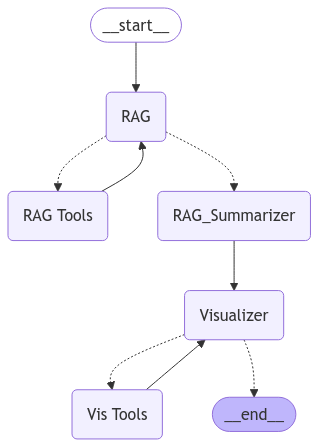

In [16]:
agent = GraphAgent(arango_graph, G_adb)


In [17]:
def create_gradio_interface(agent):
    def get_sample_data():
        # Get sample user IDs
        user_cursor = G_adb.query("""
        FOR user IN Users
        LET gameCount = (
            FOR play IN plays
            FILTER play._from == user._id
            COLLECT WITH COUNT INTO count
            RETURN count
        )[0]
        SORT gameCount DESC
        LIMIT 5
        RETURN user._id
        """)
        # Extract only the numeric ID part from the full ID (format: Users/253622624)
        sample_users = [user.split('/')[1] if '/' in user else user for user in user_cursor]

        # Get top games by player count
        games_cursor = G_adb.query("""
        WITH Games, plays
        FOR game IN Games
        LET playerCount = (
            FOR play IN plays 
            FILTER play._to == game._id 
            COLLECT WITH COUNT INTO length 
            RETURN length
        )[0]
        SORT playerCount DESC
        LIMIT 5
        RETURN game.GameName
        """)
        sample_games = [game for game in games_cursor]

        return sample_users, sample_games
    
    # Add a copy function
    def copy_to_input(text, current_input):
        if current_input:
            return current_input + " " + text
        return text

    def display_response(input_text):
        # Use a timestamp to differentiate between different query executions
        from datetime import datetime
        timestamp = datetime.now().strftime("%H:%M:%S")
        
        print(f"\n[{timestamp}] Processing new query: {input_text}")
        
        # Process the query
        result = agent.query_graph(input_text)
        
        print(f"[{timestamp}] Query processing completed")

        
            # Add more verbose debugging
        print(f"[{timestamp}] Result keys: {list(result.keys())}")
        print(f"[{timestamp}] Has_Visualization value: {result.get('Has_Visualization')}")
        print(f"[{timestamp}] Has_Visualization type: {type(result.get('Has_Visualization'))}")
        has_visualization = str(result.get("Has_Visualization", "")).lower() == "true"
        print(f"[{timestamp}] Final has_visualization value: {has_visualization}")
        # Return both the response and whether to show the visualization button
        return result["rag_reply"], has_visualization
    
    def open_html_in_new_tab():
        # Path to the HTML file
        html_path = Path("generated.html").absolute()
        
        # Check if file exists
        if not html_path.exists():
            return "Error: generated.html file not found."
        
        # Convert to file URL format
        file_url = f"file://{html_path}"
        
        # Open URL in a new tab using threading to avoid blocking
        threading.Thread(target=lambda: webbrowser.open_new_tab(file_url)).start()
        
        return "Opening visualization in a new browser tab..."
    
    # Get sample data from graph
    sample_users, sample_games = get_sample_data()
    # Custom JavaScript for copy functionality
 

    
    css = """
    .sample-panel {
        background: #2d2d2d;
        border-radius: 8px;
        padding: 15px;
        margin-top: 10px;
    }
    
    .sample-panel h3 {
        color: #f0f0f0;
        font-size: 16px;
        margin-bottom: 10px;
        text-align: center;
        border-bottom: 1px solid #444;
        padding-bottom: 5px;
    }
    
    .sample-item {
        display: flex;
        align-items: center;
        margin-bottom: 8px;
        gap: 8px;
    }
    
    .sample-text {
        font-family: monospace;
        background: #333;
        padding: 4px 8px;
        border-radius: 4px;
        flex-grow: 1;
    }
    
    .copy-btn {
        padding: 2px 8px !important;
        min-width: unset !important;
        height: 26px !important;
        font-size: 12px !important;
    }


        /* Increase text size for query input */
    .larger-text textarea {
        font-size: 18px !important;
        line-height: 1.5 !important;
    }

    /* Increase text size for result output */
    .analysis-result {
        font-size: 18px !important;
        line-height: 1.6 !important;
        padding: 15px;
        margin-top: 15px;
        min-height: 100px;
        max-height: 500px;
        overflow-y: auto;
    }

    .analysis-result p, .analysis-result li {
        font-size: 18px !important;
    }

    .analysis-result strong, .analysis-result b {
        font-weight: bold;
        font-size: 18px !important;
    }   
    """
    
     # Sample IDs panel with copyable items

    
    with gr.Blocks(css=css) as interface:
        gr.Markdown("# Graph Analysis Interface")
         
    
        with gr.Row():
            with gr.Column(scale=2):
                input_text = gr.Textbox(
                    label="Query",
                    placeholder="Enter your graph query here...",
                    lines=2,
                    elem_classes=["larger-text"]
                )
                submit_btn = gr.Button("Analyze", variant="primary")
                
                # Move text output below the analyze button
                text_output = gr.Markdown(
                    label="Analysis Result", 
                    elem_classes=["analysis-result"]
                )
                
                # Place the visualization button below the text output
                open_btn = gr.Button("Open Visualization in New Tab", visible=False)
            
            # Sample IDs panel
            with gr.Column(scale=1):
                # Create a simple interface with buttons for each item
                with gr.Column(elem_classes=["sample-panel"]):
                    gr.Markdown("### Sample User IDs")
                    
                    # Create a row of buttons for each user ID
                    for user in sample_users:
                        user_btn = gr.Button(f"{user}", elem_classes=["sample-text"])
                        user_btn.click(
                            fn=copy_to_input, 
                            inputs=[gr.Textbox(value=user, visible=False), input_text], 
                            outputs=input_text
                        )
                
                # Games section
                with gr.Column(elem_classes=["sample-panel"]):
                    gr.Markdown("### Popular Games")
                    
                    # Create a row of buttons for each game
                    for game in sample_games:
                        game_btn = gr.Button(f"{game}", elem_classes=["sample-text"])
                        game_btn.click(
                            fn=copy_to_input, 
                            inputs=[gr.Textbox(value=game, visible=False), input_text], 
                            outputs=input_text
                        )
        
        def update_ui(response, show_button):
            print(f"update_ui called with show_button={show_button}")
            return response, gr.update(visible=show_button)
                    
        # THIS IS THE FIXED LINE - Use lambda to call update_ui with the results from display_response
        submit_btn.click(
            fn=lambda x: update_ui(*display_response(x)),
            inputs=[input_text],
            outputs=[text_output, open_btn]
        )
        
        open_btn.click(
            fn=open_html_in_new_tab,
            inputs=[],
            outputs=[]
        )

    return interface

In [18]:
interface = create_gradio_interface(agent)
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



[00:10:10] Processing new query: Find 2nd and 4th Most influential game in the graph and the users who played them

Processing Agent State:
NetworkX Query received:
Identify the 2nd and 4th most influential games in the graph based on centrality measures.
----------
1) Generating NetworkX code
----------
import networkx as nx

# Calculate degree centrality for the graph
degree_centrality = nx.degree_centrality(G_adb)

# Filter out only the 'Games' nodes
games_centrality = {node: centrality for node, centrality in degree_centrality.items() if node.startswith('Games/')}

# Sort games by centrality in descending order
sorted_games = sorted(games_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the 2nd and 4th most influential games
second_most_influential_game = sorted_games[1]
fourth_most_influential_game = sorted_games[3]

# Retrieve the full node data for these games
second_game_node = G_adb.nodes[second_most_influential_game[0]]
fourth_game_node = G_adb.nodes[fourth_most_

/mnt/mydisk/Projects/ArangoGraphRag/ArangoGraphDirectChain.py:205: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  aql_generation_chain = LLMChain(llm=llm, prompt=aql_generation_prompt)
/mnt/mydisk/Projects/ArangoGraphRag/ArangoGraphDirectChain.py:257: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  aql_generation_output = self.aql_generation_chain.run(


AQL tool query
Find all users who have played the game 'Team Fortress 2' and 'Unturned'.


> Entering new ArangoGraphDirectChain chain...
AQL Query (1):
WITH Users, Games, plays
LET tf2_players = (
    FOR play IN plays
    FILTER play._to == @influential_games.2nd_most_influential_game.node_data.data._id
    RETURN play._from
)
LET unturned_players = (
    FOR play IN plays 
    FILTER play._to == @influential_games.4th_most_influential_game.node_data.data._id
    RETURN play._from
)
FOR user_id IN INTERSECTION(tf2_players, unturned_players)
    RETURN DOCUMENT(user_id)

AQL Query Execution Error: 
syntax error, unexpected number near '.2nd_most_influential_game.node_...' at position 5:42

AQL Query (2):
WITH Users, Games, plays
LET tf2_players = (
    FOR play IN plays
    FILTER play._to == @influential_games["2nd_most_influential_game"].node_data.data._id
    RETURN play._from
)
LET unturned_players = (
    FOR play IN plays 
    FILTER play._to == @influential_games["4th_most_infl

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/gradio/blocks.py:1831: UserWarning: A function (open_html_in_new_tab) returned too many output values (needed: 0, returned: 1). Ignoring extra values.
    Output components:
        []
    Output values returned:
        ["Opening visualization in a new browser tab..."]
  warnings.warn(


Opening in existing browser session.

[00:38:33] Processing new query: top 3 user who played the most number of games and the games they played

Processing Agent State:
AQL tool query
Find the top 3 users who have played the most number of different games and list the games they have played.


> Entering new ArangoGraphDirectChain chain...
AQL Query (1):
WITH Users, Games, plays
FOR user IN Users
LET played_games = (
    FOR play IN plays
    FILTER play._from == user._id
    LET game = DOCUMENT(play._to)
    RETURN game
)
LET unique_games_count = LENGTH(played_games)
SORT unique_games_count DESC
LIMIT 3
RETURN {
    user: user,
    number_of_games: unique_games_count,
    games: played_games
}

AQL Result:
[{'user': {'_key': '62990992', '_id': 'Users/62990992', '_rev': '_jT6zLJa--P', 'type': 'Users', 'steamid': 62990992}, 'number_of_games': 498, 'games': [{'_key': '11389_counter_strike_global_offensive', '_id': 'Games/11389_counter_strike_global_offensive', '_rev': '_jT6zNTy--m', 'typ

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/gradio/blocks.py:1831: UserWarning: A function (open_html_in_new_tab) returned too many output values (needed: 0, returned: 1). Ignoring extra values.
    Output components:
        []
    Output values returned:
        ["Opening visualization in a new browser tab..."]
  warnings.warn(


Opening in existing browser session.

[00:39:56] Processing new query: Identify and visualize the core-periphery structure of the gaming network

Processing Agent State:
NetworkX Query received:
Analyze the core-periphery structure of the gaming network using the plays relationships between Users and Games. Identify the core nodes (most central users and games) and the periphery nodes (less central users and games).
----------
1) Generating NetworkX code
----------
import networkx as nx
from collections import Counter

# Step 1: Use Label Propagation for community detection
communities = nx.community.label_propagation_communities(G_adb)
communities = list(communities)

# Step 2: Analyze communities to identify core and periphery nodes
community_stats = []
core_nodes = set()
periphery_nodes = set()

for idx, community in enumerate(communities):
    # Count node types (Users, Games, etc.)
    node_types = Counter(node.split('/')[0] for node in community)
    
    # Determine core and per

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/gradio/blocks.py:1831: UserWarning: A function (open_html_in_new_tab) returned too many output values (needed: 0, returned: 1). Ignoring extra values.
    Output components:
        []
    Output values returned:
        ["Opening visualization in a new browser tab..."]
  warnings.warn(


Opening in existing browser session.

[00:41:52] Processing new query: What games should we recommend to retain users who only play a single game?

Processing Agent State:
AQL tool query
Find users who only play a single game and the game they play.


> Entering new ArangoGraphDirectChain chain...
AQL Query (1):
WITH Users, Games, plays
FOR user IN Users
LET user_games = (
    FOR play IN plays
    FILTER play._from == user._id
    RETURN play
)
FILTER LENGTH(user_games) == 1
LET game = DOCUMENT(user_games[0]._to)
RETURN {
    user: user,
    game: game,
    hours_played: user_games[0].weight
}

AQL Result:
[{'user': {'_key': '187131847', '_id': 'Users/187131847', '_rev': '_jT6zKqy--A', 'type': 'Users', 'steamid': 187131847}, 'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jT6zNTy--U', 'type': 'Games', 'GameName': 'Dota 2'}, 'hours_played': 2.3}, {'user': {'_key': '140954425', '_id': 'Users/140954425', '_rev': '_jT6zKqy--D', 'type': 'Users', 'steamid': 140954425

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/gradio/blocks.py:1831: UserWarning: A function (open_html_in_new_tab) returned too many output values (needed: 0, returned: 1). Ignoring extra values.
    Output components:
        []
    Output values returned:
        ["Opening visualization in a new browser tab..."]
  warnings.warn(


Opening in existing browser session.

[00:43:51] Processing new query: Which users are potential micro-influencers based on their central position in gaming communities?

Processing Agent State:
NetworkX Query received:
Identify users who are potential micro-influencers by analyzing their centrality in the gaming community network. Consider users with high betweenness centrality as potential micro-influencers.
----------
1) Generating NetworkX code
----------
import networkx as nx

# Step 1: Calculate betweenness centrality using approximation
# Using k=100 for approximation to balance performance and accuracy
betweenness_centrality = nx.betweenness_centrality(G_adb, k=100, endpoints=True, normalized=True)

# Step 2: Identify potential micro-influencers
# Define a threshold for high betweenness centrality
# Here, we consider the top 1% as potential micro-influencers
threshold = sorted(betweenness_centrality.values(), reverse=True)[int(0.01 * len(betweenness_centrality))]

# Filter user

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/gradio/blocks.py:1831: UserWarning: A function (open_html_in_new_tab) returned too many output values (needed: 0, returned: 1). Ignoring extra values.
    Output components:
        []
    Output values returned:
        ["Opening visualization in a new browser tab..."]
  warnings.warn(


Opening in existing browser session.

[00:46:01] Processing new query: Identify 'game tribes' - groups of users who predominantly play within a specific set of games

Processing Agent State:
NetworkX Query received:
Detect communities of users who predominantly play the same set of games. Use community detection algorithms to identify these 'game tribes' based on the 'plays' relationships between users and games.
----------
1) Generating NetworkX code
----------
import networkx as nx
from collections import Counter

# Use Louvain method for community detection, which is efficient for large graphs
communities = nx.community.louvain_communities(G_adb, weight='weight')
communities = list(communities)

# Analyze all communities
community_stats = []
for idx, community in enumerate(communities):
    # Count node types (Users, Games, etc.)
    node_types = Counter(node.split('/')[0] for node in community)
    
    # Collect detailed node information for each community
    nodes_info = []
    

[00:46:12 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[00:46:14 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[00:46:14 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[00:46:14 -0600] [WARNING]: Database environment variables not set. Can't connect to the database


Converted FINAL_RESULT to serializable format

Processing Agent State:

RAG_Summarizer State:

Updating RAG_reply with:
The analysis has identified 61 'game tribes', which are communities of users who predominantly play within specific sets of games. Here are some details about two of these communities:

1. **Community 15**:
   - Size: 4027 members
   - Composition: 3916 Users and 111 Games

2. **Community 12**:
   - Size: 2679 members
   - Composition: 1450 Users and 1229 Games

These communities represent groups of users who share similar gaming interests, often playing the same or similar games.
Visualizer State:
[ HumanMessage(content="Identify 'game tribes' - groups of users who predominantly play within a specific set of games", additional_kwargs={}, response_metadata={}, id='19a44097-7723-411c-a955-52ad64d9755f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rbl9WEDEpa744ZLyahORIugx', 'function': {'arguments': '{"query":"Detect communities of users who 

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/gradio/blocks.py:1831: UserWarning: A function (open_html_in_new_tab) returned too many output values (needed: 0, returned: 1). Ignoring extra values.
    Output components:
        []
    Output values returned:
        ["Opening visualization in a new browser tab..."]
  warnings.warn(


Opening in existing browser session.
